# Задание 6: Рекуррентные нейронные сети (RNNs)

Это задание адаптиповано из Deep NLP Course at ABBYY (https://github.com/DanAnastasyev/DeepNLP-Course) с разрешения автора - Даниила Анастасьева. Спасибо ему огромное!

In [1]:
# !pip3 -qq install torch==0.4.1
# !pip3 -qq install bokeh==0.13.0
# !pip3 -qq install gensim==4.1.1
# !pip3 -qq install nltk
# !pip3 -qq install scikit-learn==0.20.2

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor

np.random.seed(42)

# Рекуррентные нейронные сети (RNNs)

## POS Tagging

Мы рассмотрим применение рекуррентных сетей к задаче sequence labeling (последняя картинка).

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg)

*From [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*

Самые популярные примеры для такой постановки задачи - Part-of-Speech Tagging и Named Entity Recognition.

Мы порешаем сейчас POS Tagging для английского.

Будем работать с таким набором тегов:
- ADJ - adjective (new, good, high, ...)
- ADP - adposition (on, of, at, ...)
- ADV - adverb (really, already, still, ...)
- CONJ - conjunction (and, or, but, ...)
- DET - determiner, article (the, a, some, ...)
- NOUN - noun (year, home, costs, ...)
- NUM - numeral (twenty-four, fourth, 1991, ...)
- PRT - particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- . - punctuation marks (. , ;)
- X - other (ersatz, esprit, dunno, ...)

Скачаем данные:

In [2]:
import nltk
from sklearn.model_selection import train_test_split

nltk.download('brown')
nltk.download('universal_tagset')

data = nltk.corpus.brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


Пример размеченного предложения:

In [3]:
for word, tag in data[0]:
    print('{:15}\t{}'.format(word, tag))

The            	DET
Fulton         	NOUN
County         	NOUN
Grand          	ADJ
Jury           	NOUN
said           	VERB
Friday         	NOUN
an             	DET
investigation  	NOUN
of             	ADP
Atlanta's      	NOUN
recent         	ADJ
primary        	NOUN
election       	NOUN
produced       	VERB
``             	.
no             	DET
evidence       	NOUN
''             	.
that           	ADP
any            	DET
irregularities 	NOUN
took           	VERB
place          	NOUN
.              	.


Построим разбиение на train/val/test - наконец-то, всё как у нормальных людей.

На train будем учиться, по val - подбирать параметры и делать всякие early stopping, а на test - принимать модель по ее финальному качеству.

In [4]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

print('Words count in train set:', sum(len(sent) for sent in train_data))
print('Words count in val set:', sum(len(sent) for sent in val_data))
print('Words count in test set:', sum(len(sent) for sent in test_data))

Words count in train set: 739769
Words count in val set: 130954
Words count in test set: 290469


Построим маппинги из слов в индекс и из тега в индекс:


In [5]:
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words)}
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind + 1 for ind, tag in enumerate(tags)}
tag2ind['<pad>'] = 0

print('Unique words in train = {}. Tags = {}'.format(len(word2ind), tags))

Unique words in train = 45441. Tags = {'DET', 'VERB', 'CONJ', 'PRT', 'ADV', 'X', '.', 'NUM', 'NOUN', 'ADP', 'ADJ', 'PRON'}


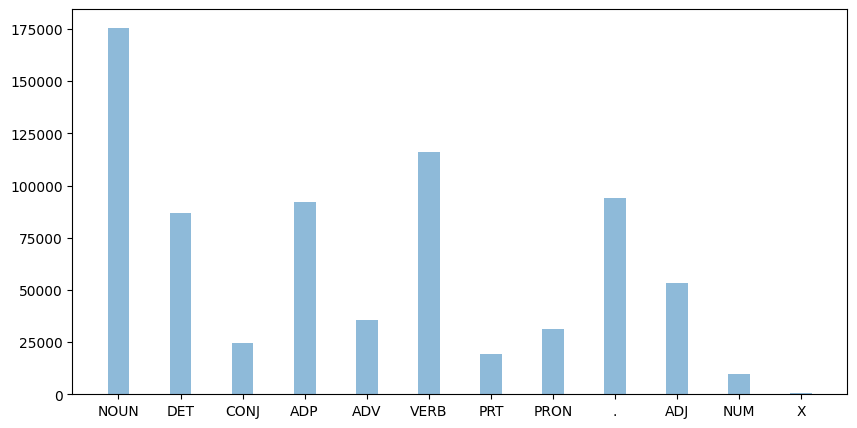

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))

bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags)
    
plt.show()

## Бейзлайн

Какой самый простой теггер можно придумать? Давайте просто запоминать, какие теги самые вероятные для слова (или для последовательности):

![tag-context](https://www.nltk.org/images/tag-context.png)  
*From [Categorizing and Tagging Words, nltk](https://www.nltk.org/book/ch05.html)*

На картинке показано, что для предсказания $t_n$ используются два предыдущих предсказанных тега + текущее слово. По корпусу считаются вероятность для $P(t_n| w_n, t_{n-1}, t_{n-2})$, выбирается тег с максимальной вероятностью.

Более аккуратно такая идея реализована в Hidden Markov Models: по тренировочному корпусу вычисляются вероятности $P(w_n| t_n), P(t_n|t_{n-1}, t_{n-2})$ и максимизируется их произведение.

Простейший вариант - униграммная модель, учитывающая только слово:

In [9]:
import nltk

default_tagger = nltk.DefaultTagger('NN')

unigram_tagger = nltk.UnigramTagger(train_data, backoff=default_tagger)
print('Accuracy of unigram tagger = {:.2%}'.format(unigram_tagger.accuracy(test_data)))

Accuracy of unigram tagger = 92.62%


Добавим вероятности переходов:

In [11]:
bigram_tagger = nltk.BigramTagger(train_data, backoff=unigram_tagger)
print('Accuracy of bigram tagger = {:.2%}'.format(bigram_tagger.accuracy(test_data)))

Accuracy of bigram tagger = 93.42%


Обратите внимание, что `backoff` важен:

In [12]:
trigram_tagger = nltk.TrigramTagger(train_data)
print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.accuracy(test_data)))

Accuracy of trigram tagger = 23.33%


In [15]:
trigram_tagger = nltk.TrigramTagger(train_data, backoff=bigram_tagger)
print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.accuracy(test_data)))

Accuracy of trigram tagger = 93.43%


## Увеличиваем контекст с рекуррентными сетями

Униграмная модель работает на удивление хорошо, но мы же собрались учить сеточки.

Омонимия - основная причина, почему униграмная модель плоха:  
*“he cashed a check at the **bank**”*  
vs  
*“he sat on the **bank** of the river”*

Поэтому нам очень полезно учитывать контекст при предсказании тега.

Воспользуемся LSTM - он умеет работать с контекстом очень даже хорошо:

![](https://image.ibb.co/kgmoff/Baseline-Tagger.png)

Синим показано выделение фичей из слова, LSTM оранжевенький - он строит эмбеддинги слов с учетом контекста, а дальше зелененькая логистическая регрессия делает предсказания тегов.

In [6]:
def convert_data(data, word2ind, tag2ind):
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]
    
    return X, y

X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [7]:
def iterate_batches(data, batch_size):
    X, y = data
    n_samples = len(X)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_indices = indices[start:end]
        
        max_sent_len = max(len(X[ind]) for ind in batch_indices)
        X_batch = np.zeros((max_sent_len, len(batch_indices)))
        y_batch = np.zeros((max_sent_len, len(batch_indices)))
        
        for batch_ind, sample_ind in enumerate(batch_indices):
            X_batch[:len(X[sample_ind]), batch_ind] = X[sample_ind]
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]
            
        yield X_batch, y_batch

In [8]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 4))

X_batch.shape, y_batch.shape

((32, 4), (32, 4))

**Задание** Реализуйте `LSTMTagger`:

In [33]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        self.emb = nn.Embedding(vocab_size, word_emb_dim)
        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, lstm_layers_count)
        self.lin = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        emb_out = self.emb(inputs)
        lstm_out, _ = self.lstm(emb_out)
        return self.lin(lstm_out)

**Задание** Научитесь считать accuracy и loss (а заодно проверьте, что модель работает)

In [9]:
def calculate_acc(y_batch, logits):
    mask = (y_batch != 0).float()
    preds = torch.argmax(logits, 2)
  
    current_count = ((preds == y_batch).float() * mask).sum()
    total_count = mask.sum()

    # for the 1 try
#     return current_count / total_count

    # for do_epoch()
    return current_count, total_count

In [10]:
def calculate_loss(criterion, y_batch, logits):
    return criterion(logits.transpose(2, 1), y_batch)

In [36]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

logits = model(X_batch)

print('Accuracy: {:.3}'.format(calculate_acc(y_batch, logits)))

Accuracy: 0.0326


In [37]:
criterion = nn.CrossEntropyLoss()
print('Loss : {:.3}'.format(calculate_loss(criterion, y_batch, logits)))

Loss : 2.6


**Задание** Вставьте эти вычисление в функцию:

In [11]:
import math
from tqdm import tqdm


def do_epoch(model, criterion, data, batch_size, optimizer=None, name=None):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = math.ceil(len(data[0]) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
                X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)
                logits = model(X_batch)

                loss = calculate_loss(criterion, y_batch, logits)

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                cur_correct_count, cur_sum_count = calculate_acc(y_batch, logits)

                correct_count += cur_correct_count
                sum_count += cur_sum_count

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                    name, loss.item(), cur_correct_count / cur_sum_count)
                )
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                name, epoch_loss / batches_count, correct_count / sum_count)
            )

    return epoch_loss / batches_count, correct_count / sum_count


def fit(model, criterion, optimizer, train_data, epochs_count=1, batch_size=32,
        val_data=None, val_batch_size=None):
        
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = do_epoch(model, criterion, train_data, batch_size, optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss, val_acc = do_epoch(model, criterion, val_data, val_batch_size, None, name_prefix + '  Val:')

In [40]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

# epochs_count=50 leads to overfitting
fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=20,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 20] Train: Loss = 0.31892, Accuracy = 71.34%: 100%|██████████| 572/572 [00:04<00:00, 122.57it/s]
[1 / 20]   Val: Loss = 0.09904, Accuracy = 85.54%: 100%|██████████| 13/13 [00:00<00:00, 75.51it/s]
[2 / 20] Train: Loss = 0.10145, Accuracy = 89.80%: 100%|██████████| 572/572 [00:04<00:00, 129.75it/s]
[2 / 20]   Val: Loss = 0.07082, Accuracy = 90.02%: 100%|██████████| 13/13 [00:00<00:00, 74.58it/s]
[3 / 20] Train: Loss = 0.06803, Accuracy = 93.20%: 100%|██████████| 572/572 [00:04<00:00, 129.72it/s]
[3 / 20]   Val: Loss = 0.06152, Accuracy = 91.29%: 100%|██████████| 13/13 [00:00<00:00, 74.14it/s]
[4 / 20] Train: Loss = 0.05103, Accuracy = 94.80%: 100%|██████████| 572/572 [00:04<00:00, 117.01it/s]
[4 / 20]   Val: Loss = 0.06076, Accuracy = 92.21%: 100%|██████████| 13/13 [00:00<00:00, 61.86it/s]
[5 / 20] Train: Loss = 0.04075, Accuracy = 95.82%: 100%|██████████| 572/572 [00:04<00:00, 126.36it/s]
[5 / 20]   Val: Loss = 0.06065, Accuracy = 92.67%: 100%|██████████| 13/13 [00:00<00:00, 74.97i

### Masking

**Задание** Проверьте себя - не считаете ли вы потери и accuracy на паддингах - очень легко получить высокое качество за счет этого.

У функции потерь есть параметр `ignore_index`, для таких целей. Для accuracy нужно использовать маскинг - умножение на маску из нулей и единиц, где нули на позициях паддингов (а потом усреднение по ненулевым позициям в маске).

**Задание** Посчитайте качество модели на тесте. Ожидается результат лучше бейзлайна!

In [43]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

logits = model(X_batch)
print('Accuracy: {:.3}'.format(calculate_acc(y_batch, logits)))

criterion = nn.CrossEntropyLoss(ignore_index=0)
print('Loss : {:.3}'.format(calculate_loss(criterion, y_batch, logits)))

Accuracy: 0.0652
Loss : 2.56


### Bidirectional LSTM

Благодаря BiLSTM можно использовать сразу оба контеста при предсказании тега слова. Т.е. для каждого токена $w_i$ forward LSTM будет выдавать представление $\mathbf{f_i} \sim (w_1, \ldots, w_i)$ - построенное по всему левому контексту - и $\mathbf{b_i} \sim (w_n, \ldots, w_i)$ - представление правого контекста. Их конкатенация автоматически захватит весь доступный контекст слова: $\mathbf{h_i} = [\mathbf{f_i}, \mathbf{b_i}] \sim (w_1, \ldots, w_n)$.

![BiLSTM](https://www.researchgate.net/profile/Wang_Ling/publication/280912217/figure/fig2/AS:391505383575555@1470353565299/Illustration-of-our-neural-network-for-POS-tagging.png)  
*From [Finding Function in Form: Compositional Character Models for Open Vocabulary Word Representation](https://arxiv.org/abs/1508.02096)*

**Задание** Добавьте Bidirectional LSTM.

In [49]:
class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        self.emb = nn.Embedding(vocab_size, word_emb_dim)
        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, 
                            lstm_layers_count, bidirectional=True)
        self.lin = nn.Linear(lstm_hidden_dim*2, tagset_size)

    def forward(self, inputs):
        emb_out = self.emb(inputs)
        lstm_out, _ = self.lstm(emb_out)
        return self.lin(lstm_out)

In [50]:
model = BiLSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=5,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[5 / 5]   Val: Loss = 0.15267, Accuracy = 95.40%: 100%|██████████| 13/13 [00:00<00:00, 43.67it/s]


### Предобученные эмбеддинги

Мы знаем, какая клёвая вещь - предобученные эмбеддинги. При текущем размере обучающей выборки еще можно было учить их и с нуля - с меньшей было бы совсем плохо.

Поэтому стандартный пайплайн - скачать эмбеддинги, засунуть их в сеточку. Запустим его:

In [12]:
import gensim.downloader as api

w2v_model = api.load('glove-wiki-gigaword-100')

Построим подматрицу для слов из нашей тренировочной выборки:

In [13]:
known_count = 0
embeddings = np.zeros((len(word2ind), w2v_model.vectors.shape[1]))
for word, ind in word2ind.items():
    word = word.lower()
    if word in w2v_model:
        embeddings[ind] = w2v_model.get_vector(word)
        known_count += 1
        
print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))

Know 38736 out of 45441 word embeddings


In [14]:
embeddings = torch.FloatTensor(embeddings)

**Задание** Сделайте модель с предобученной матрицей. Используйте `nn.Embedding.from_pretrained`.

In [15]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embeddings, tagset_size, lstm_hidden_dim=64, lstm_layers_count=1):
        super().__init__()
        
        self.emb = nn.Embedding.from_pretrained(embeddings)
        self.lstm = nn.LSTM(embeddings.shape[1], lstm_hidden_dim, lstm_layers_count)
        self.lin = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        emb_out = self.emb(inputs)
        lstm_out, _ = self.lstm(emb_out)
        return self.lin(lstm_out)

In [16]:
model = LSTMTaggerWithPretrainedEmbs(
    embeddings=embeddings,
    tagset_size=len(tag2ind)
)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=15,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 15] Train: Loss = 0.75879, Accuracy = 78.06%: 100%|█████████████████████████████| 572/572 [00:13<00:00, 41.05it/s]
[1 / 15]   Val: Loss = 0.37370, Accuracy = 89.06%: 100%|███████████████████████████████| 13/13 [00:00<00:00, 13.61it/s]
[2 / 15] Train: Loss = 0.28644, Accuracy = 91.33%: 100%|█████████████████████████████| 572/572 [00:13<00:00, 41.06it/s]
[2 / 15]   Val: Loss = 0.25939, Accuracy = 91.93%: 100%|███████████████████████████████| 13/13 [00:00<00:00, 13.17it/s]
[3 / 15] Train: Loss = 0.21069, Accuracy = 93.35%: 100%|█████████████████████████████| 572/572 [00:14<00:00, 40.71it/s]
[3 / 15]   Val: Loss = 0.21210, Accuracy = 93.27%: 100%|███████████████████████████████| 13/13 [00:00<00:00, 13.40it/s]
[4 / 15] Train: Loss = 0.17419, Accuracy = 94.43%: 100%|█████████████████████████████| 572/572 [00:14<00:00, 40.34it/s]
[4 / 15]   Val: Loss = 0.18700, Accuracy = 94.02%: 100%|███████████████████████████████| 13/13 [00:01<00:00, 12.90it/s]
[5 / 15] Train: Loss = 0.15307, Accuracy

**Задание** Оцените качество модели на тестовой выборке. Обратите внимание, вовсе не обязательно ограничиваться векторами из урезанной матрицы - вполне могут найтись слова в тесте, которых не было в трейне и для которых есть эмбеддинги.

Добейтесь качества лучше прошлых моделей.

In [30]:
def test(model, criterion, test_data, batch_size):
    model.eval()
    
    epoch_loss = 0
    correct_count = 0
    sum_count = 0
    
    batches_count = math.ceil(len(test_data[0]) / batch_size)
    with torch.no_grad():
        with tqdm(total=batches_count) as progress_bar:
            
            for i, (X_batch, y_batch) in enumerate(iterate_batches(test_data, batch_size)):
                X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)
                logits = model(X_batch)

                loss = calculate_loss(criterion, y_batch, logits)
                epoch_loss += loss.item()
                
                cur_correct_count, cur_sum_count = calculate_acc(y_batch, logits)
                correct_count += cur_correct_count
                sum_count += cur_sum_count

                progress_bar.update()
                progress_bar.set_description('Loss = {:.5f}, Accuracy = {:.2%}'.format(
                    loss.item(), cur_correct_count / cur_sum_count)
                )
                
            progress_bar.set_description('Loss = {:.5f}, Accuracy = {:.2%}'.format(
                epoch_loss / batches_count, correct_count / sum_count)
            )

    return epoch_loss / batches_count, correct_count / sum_count

In [31]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
test(model, criterion, test_data=(X_test, y_test), batch_size=512)

Loss = 2.57998, Accuracy = 4.92%: 100%|████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.21it/s]


(2.579976328781673, tensor(0.0492))